In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from util.TSB_AD.metrics import metricor
from util.TSB_AD.slidingWindows import find_length #,plotFig, printResult
from sklearn.preprocessing import MinMaxScaler
import os
import sys
import copy

from util.plot_aadd import *
from util.util_a2d2 import *

# from scipy.io import arff
import arff

# from tqdm.notebook import tqdm
import time
import math
from util.TranAD_base import *
from util.TSB_AD.models.norma import NORMA
from util.TSB_AD.models.a2d2 import A2D2
from util.TSB_AD.models.sand import SAND
from util.TSB_AD.models.damp import DAMP
import warnings
warnings.filterwarnings('ignore')
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:olive', 'tab:pink', 'tab:cyan', 'tab:gray', 
          'blue', 'orange', 'green', 'purple','brown', 'gold', 'violet', 'cyan', 'pink', 'deepskyblue', 'lawngreen',
          'royalblue', 'darkgrey', 'darkorange', 'darkgreen','darkviolet','salmon','olivedrab','lightcoral','darkcyan','yellowgreen']
markers = ['o', 'x', '^', 'v', 's', '*', '+', '.', ',', '<', '>' , '1','2','3','4','p','h','H','D','d']

In [20]:
rst_columns =['AUC', 'R_AUC', 'Precision', 'Recall', 'F1', 'AP', 'R_AP', 'RPrecision', 'RRecall']

def read_arff(filename):
    """
    Find ndarray corresponding to data and labels from arff data
    """
    arff_content = arff.load(f.replace(',\n', '\n') for f in open(filename, 'r'))
    arff_data = arff_content['data']
    data = np.array([i[:1] for i in arff_data])
    anomaly_labels = np.array([i[-1] for i in arff_data])
    anomaly_labels = anomaly_labels.reshape((len(anomaly_labels),1))
    return data.astype(float), anomaly_labels.astype(float)

def get_acc(label, score, slidingWindow, ths=None):
    
    result = pd.DataFrame(columns=rst_columns)
    grader = metricor()
    if np.sum(label) != 0:
        R_AUC, R_AP, R_fpr, R_tpr, R_prec = grader.RangeAUC(labels=label, score=score, window=slidingWindow, plot_ROC=True)
        L = grader.metric_new(label, score, ths=ths)
        # print(L)
        
        precision, recall, AP = grader.metric_PR(label, score)
        # print(f'Precision? {precision}, Recall? {recall}'
        
        result.loc[0] = [L[0], R_AUC, L[1], L[2], L[3], AP, R_AP, L[4], L[7]]
        return result
    
def training_model(train_loader, test_loader, NN_model, labels, dataset):
    ########################################################################
    ## For training DNNs (in terms of TranAD and related references)

    model, optimizer, scheduler, epoch, accuracy_list = load_model(NN_model, labels.shape[1])
    
    ## Prepare data
    trainD, testD = next(iter(train_loader)), next(iter(test_loader))
    trainO, testO = trainD, testD
    if model.name in ['Attention', 'DAGMM', 'USAD', 'MSCRED', 'CAE_M', 'GDN', 'MTAD_GAT', 'MAD_GAN'] or 'TranAD' in model.name: 
        trainD, testD = convert_to_windows(trainD, model), convert_to_windows(testD, model)
        
    ### Training phase
    print(f'{color.HEADER}Training {NN_model} on {dataset}{color.ENDC}')
    num_epochs = 5; e = epoch + 1; start = time()
    for e in list(range(epoch+1, epoch+num_epochs+1)):
        lossT, lr = backprop(e, model, trainD, trainO, optimizer, scheduler)
        accuracy_list.append((lossT, lr))
    print(color.BOLD+'Training time: '+"{:10.4f}".format(time()-start)+' s'+color.ENDC)
    save_model(model, optimizer, scheduler, e, accuracy_list)
	# plot_accuracies(accuracy_list, f'{args.model}_{args.dataset}')
	# plot_accuracies(accuracy_list)
    return model, testD, testO, optimizer, scheduler

def align_score(NMs, scores, cl_s, slidingWindow):
    num_nm = len(NMs)
    rev_scores = copy.deepcopy(scores[:len(cl_s)])
    ## for each NM,
    for i in range(num_nm):
        tmp_sc = rev_scores[cl_s ==i]
        if len(tmp_sc) >0:
            tmp_sc = tmp_sc - np.mean(tmp_sc) + 0.1
            rev_scores[cl_s ==i] = tmp_sc
    rev_scores[rev_scores <0] = 0
    rev_scores = running_mean(rev_scores, slidingWindow)
    rev_scores = np.array([rev_scores[0]]*math.ceil((slidingWindow-1)//2) + list(rev_scores) + rev_scores[-1]*(slidingWindow-1)//2)

    return rev_scores


def compare_methods(data, label, slidingWindow, train_len, data_name, nm_len, overlap, kadj, normalize, selected_methods, stepwise=True, dist_org = True):
    # slidingWindow = find_length(data)
    
    ## Check for IOPS
    # if data_name == 'IOPS' and slidingWindow <120:
        # slidingWindow = 125

    if data_name == 'elec':
        slidingWindow = 48
        
    print('SlidingWindow:', slidingWindow)
    ## for DAMP
    sp_index = slidingWindow +1

    x_test = data
    scores = []
    slabels = []
    
    
    process_time = []

    ## for TranAD
    # print('Test: TranAD')
    args.dataset = 'Data'
    args.model = 'TranAD'
    args.retrain = True
    loader = []

    if 'TranAD' in selected_methods:
        loader.append(x_test[:int(train_len)].reshape(int(train_len),1))
        loader.append(x_test.reshape(len(x_test),1))
        loader.append(label.reshape(len(label),1))
        train_loader = DataLoader(loader[0], batch_size=loader[0].shape[0])
        test_loader = DataLoader(loader[1], batch_size=loader[1].shape[0])
        label_tranad = loader[2]

        start_t = time()
        model, testD, testO, optimizer, scheduler = training_model(train_loader, test_loader, args.model, label_tranad, args.dataset)

        ### Testing phase
        torch.zero_grad = True
        model.eval()
        print(f'{color.HEADER}Testing {args.model} on {args.dataset}{color.ENDC}')
        loss, y_pred = backprop(0, model, testD, testO, optimizer, scheduler, training=False)
        end_t = time()
        process_time.append(end_t-start_t)
        print('TranAD-Done (takes)', end_t - start_t)

        data_tranad = loader[1].reshape(len(loader[1]),)
        label_tranad = label_tranad.reshape(len(label_tranad),)
        # slidingWindow = find_length(data)
        score = loss
        score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
        scores.append(score[:len(x_test)])
        slabels.append('TranAD (online)\nAnomaly Score')

        print(len(scores))

    if 'NormA' in selected_methods:
        print('Test: NORMA-OFF')
        # if normalize == 'z-norm': norma_norm = True
        # else: norma_norm= False
        # norma_norm = True
        normalize_comp = 'z-norm' if dist_org else normalize

        start_t = time()
        clf_off = NORMA(pattern_length = slidingWindow, nm_size=3*slidingWindow, percentage_sel=1, normalize=normalize_comp)
        clf_off.fit(x_test)
        end_t = time()
        process_time.append(end_t -start_t)
        print('NormA-Done (takes)', end_t - start_t)
        score = clf_off.decision_scores_
        score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
        score = np.array([score[0]]*((slidingWindow-1)//2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
        scores.append(score[:len(x_test)])
        slabels.append('NormA (off)\nAnomaly Score')
    
        print(len(scores))
    if 'SAND' in selected_methods:
        modelName='SAND (online)'
        start_t = time()
        clf = SAND(pattern_length=slidingWindow,subsequence_length=4*(slidingWindow))
        x = data
        clf.fit(x,online=True,alpha=0.5,init_length=10000,batch_size=5000,verbose=True,overlaping_rate=int(4*slidingWindow))
        end_t = time()
        process_time.append(end_t -start_t)
        print('SAND-Done (takes)', end_t - start_t)
        score = clf.decision_scores_
        score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
        # plotFig(data, label, score, slidingWindow, fileName='file', modelName=modelName) #, plotRange=[1775,2200]
        scores.append(score[:len(x_test)])
        slabels.append('SAND (online)\nAnomaly Score')

        print(len(scores))
    if 'DAMP' in selected_methods:
        modelName='DAMP'
        start_t = time()
        normalize_comp = 'z-norm' if dist_org else normalize
        clf = DAMP(m = slidingWindow,sp_index=sp_index, x_lag = slidingWindow*5, normalize=normalize_comp)
        x = data
        clf.fit(x)
        end_t = time()
        process_time.append(end_t -start_t)
        print('DAMP-Done (takes)', end_t - start_t)
        score = clf.decision_scores_
        score = running_mean(score, slidingWindow)
        score = np.array([score[0]]*math.ceil((slidingWindow-1)//2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
        score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
        score = np.array([score[0]]*math.ceil((slidingWindow-1)//2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
        # plotFig(data, label, score, slidingWindow, fileName='file', modelName=modelName) #, plotRange=[1775,2200]
        scores.append(score[:len(x_test)])
        slabels.append('DAMP (online)\nAnomaly Score')

        print(len(scores))

    if 'A2D2' in selected_methods:
        ## Offline
        modelName='A2D2 (off)'
        start_t = time()
        clf = A2D2(pattern_length=slidingWindow, normalize=normalize, linkage_method='ward', th_reverse=5, kadj=kadj, nm_len=nm_len, overlap=overlap, max_W=20, eta=1)
        x = data
        clf.fit(x, y=label, online=False, training=True, training_len=int(train_len), stump=False, stepwise=stepwise)
        end_t = time()
        process_time.append(end_t -start_t)
        print('A2D2-Done (takes)', end_t - start_t)
        score = clf.scores
        score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
        score = running_mean(score, slidingWindow)
        score = np.array([score[0]]*math.ceil((slidingWindow-1)//2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
        if len(score) < len(x):
            score = np.append(score, np.ones(len(x)-len(score))*np.mean(score))
        scores.append(score[:len(x_test)])
        slabels.append('A2D2 (offline)\nAnomaly Score')
        score2 = align_score(clf.NMs, score, clf.cl_s[:len(score)], slidingWindow)
        scores.append(score2[:len(x)])
        slabels.append('A2D2 (off) Flatten')
        ## Offline
        modelName='A2D2 (on)'
        start_t = time()
        clf = A2D2(pattern_length=slidingWindow, normalize=normalize, linkage_method='ward', th_reverse=5, kadj=kadj, nm_len=nm_len, overlap=overlap, max_W=20, eta=1)
        x = data
        clf.fit(x, y=label, online=True, training=True, training_len=int(train_len), stump=False, stepwise=stepwise)
        end_t = time()
        process_time.append(end_t -start_t)
        print('A2D2-Done (takes)', end_t - start_t)
        score = clf.scores
        score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
        score = running_mean(score, slidingWindow)
        score = np.array([score[0]]*math.ceil((slidingWindow-1)//2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
        if len(score) < len(x):
            score = np.append(score, np.ones(len(x)-len(score))*np.mean(score))
        scores.append(score[:len(x_test)])
        slabels.append('A2D2 (offline)\nAnomaly Score')
        score2 = align_score(clf.NMs, score, clf.cl_s[:len(score)], slidingWindow)
        scores.append(score2[:len(x)])
        slabels.append('A2D2 (on) Flatten')
        print(len(scores))

    time_df = pd.DataFrame(process_time, columns=['time'])
    # display(time_df)
    return scores, slabels, time_df

def plot_anomaly_drift(X, y, orders, positions, widths, names, start=0, end=sys.maxsize, title="", marker="-"):
    # Plot the data with highlighted anomaly
    plt.rc('font', size=15)
    plt.rc('axes', labelsize=15)
    fig= plt.figure(figsize=(12,2))
    ax = fig.add_subplot()
    ax.plot(np.arange(start,min(X.shape[0],end)), X[start:end], f"{marker}k")
    for (anom_start, anom_end) in find_anomaly_intervals(y):
        if start <= anom_end and anom_start <= anom_end:
            anom_start = max(start, anom_start)
            anom_end = min(end, anom_end)
            ax.plot(np.arange(anom_start, anom_end), X[anom_start:anom_end], 'r-')
            # print(anom_start, anom_end)

    stream_area, Ws = split_drifts(positions, widths, len(X))
    for i, area in enumerate(stream_area):
        if area[1] <start: continue
        if area[0] > end: continue

        if orders.count(orders[i]) ==1:
            ax.axvspan(max(start, area[0]), min(area[1], end), facecolor=colors[orders[i]], alpha=0.5, label=names[orders[i]])
        else:
            if orders[i] in orders[:i]:
                ax.axvspan(max(start, area[0]), min(area[1], end), facecolor=colors[orders[i]], alpha=0.5)
            else:
                ax.axvspan(max(start, area[0]), min(area[1], end), facecolor=colors[orders[i]], alpha=0.5, label=names[orders[i]])

    for w in Ws:
        if w[1] < start: continue
        if w[0] > end: continue
        ax.axvspan(max(w[0], start), min(w[1], end), facecolor='gold', alpha=0.5)
        # ax.axvspan(max(w[0], start), min(w[1], end), facecolor='gold', alpha=0.5, label='Grad. drift')
    ax.axvspan(max(w[0], start), min(w[1], end), facecolor='gold', alpha=0.5, label='Grad. drift')
    if len(title) > 0:
        plt.title(title)
    # ax.set_xticks(np.arange(start, end, 1000))
    plt.legend(bbox_to_anchor=(0.5, 1.3), ncols=max(orders)+2, loc='upper center', facecolor='None', framealpha=0, fontsize=15)

### Load dataset: check filder path

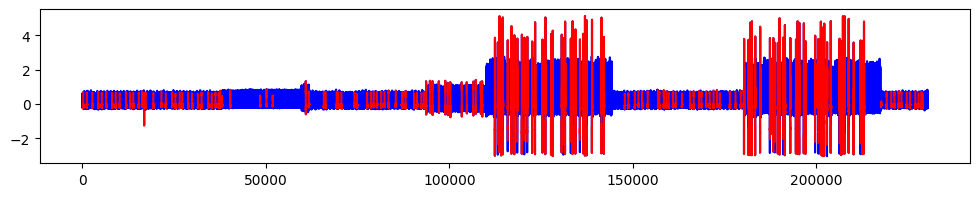

In [22]:
## Select File
data_name = 'ecg'
dir = os.getcwd() + f'/data/synthetic/{data_name}/n_drift'
f = '0_ECG_Test_n_d_grad_p0_n8_b50.arff'

data, label = read_arff(f'{dir}/{f}')
data = data.reshape(-1)
label = label.reshape(-1)
plot_anomaly(data, label)

### AnDri (Off) (with parameters)

NM: 0, Tau: 1.4491383677904495, Nu: 0.1, M: 0.6930932552741065, STD: 0.2520150375054477
NM: 1, Tau: 1.0643985782052263, Nu: 0.1, M: 0.4682749957269747, STD: 0.1987078608260839
NM: 2, Tau: 10.250132475500038, Nu: 0.609678157398066, M: 4.011862435727503, STD: 2.079423346590845
NM: 3, Tau: 3.53490196887946, Nu: 0.1, M: 1.0041307143387586, STD: 0.8435904181802338
NM: 4, Tau: 8.291715669709246, Nu: 0.7030024652763964, M: 3.4458444856611643, STD: 1.6152903946826938


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


A2D2-Done (takes) 15.236907958984375


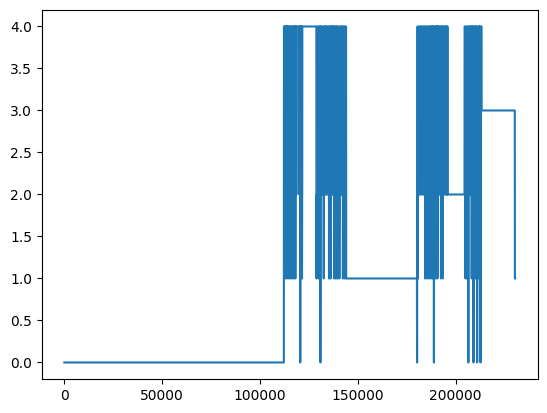

In [ ]:
slidingWindow = find_length(data[:10000])
if data_name == 'elec': slidingWindow = 48
if data_name == 'weather': slidingWindow = 24

normalize= 'zero-mean'  # default
kadj=1                  # default
nm_len=2                # default
overlap=0               # default
max_W = 20
train_len = 0.2* len(data)
stepwise=True           # default

## Offline
modelName='A2D2 (off)'
start_t = time()
clf = A2D2(pattern_length=slidingWindow, normalize=normalize, linkage_method='ward', th_reverse=5, kadj=kadj, nm_len=nm_len, overlap=overlap, max_W=max_W, eta=1)
x = data
clf.fit(x, y=label, online=False, training=True, training_len=int(train_len), stump=False, stepwise=stepwise)
end_t = time()

print('A2D2-Done (takes)', end_t - start_t)
score = clf.scores

## For fair comparison (To be moved into a2d2.py)
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = running_mean(score, slidingWindow)
score = np.array([score[0]]*math.ceil((slidingWindow-1)//2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
if len(score) < len(x):
    score = np.append(score, np.ones(len(x)-len(score))*np.mean(score))
score2 = align_score(clf.NMs, score, clf.cl_s[:len(score)], slidingWindow)


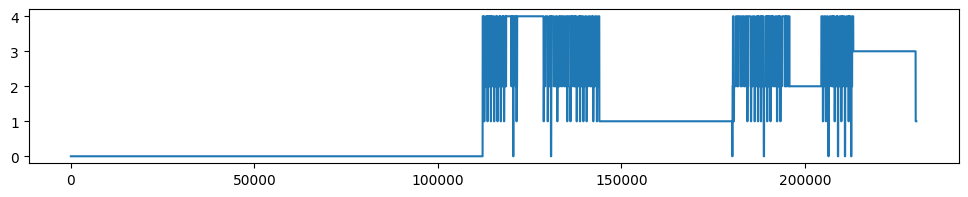

In [ ]:
## Cluster info. (for each point)
plt.figure(figsize=(12,2))
# plt.plot(clf.cl_s[110000:130000])
plt.plot(clf.cl_s)

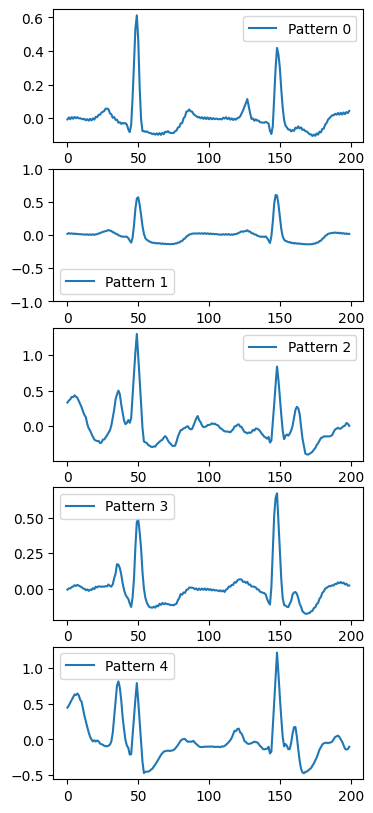

In [40]:
fig, ax = plt.subplots(len(clf.NMs),1, figsize=(4, 2*len(clf.NMs)))
for i, NM in enumerate(clf.NMs):
    ax[i].plot(NM.subseq, label=f'Pattern {i}')
    ax[i].legend()
    ax[1].set_ylim([-1,1])
    